In [1]:
!pip install kaggle

In [1]:
!kaggle datasets download 'manjilkarki/deepfake-and-real-images'

Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown
 99% 1.67G/1.68G [00:12<00:00, 233MB/s]
100% 1.68G/1.68G [00:13<00:00, 139MB/s]


In [2]:
!unzip deepfake-and-real-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Validation/Real/real_5499.jpg  
  inflating: Dataset/Validation/Real/real_55.jpg  
  inflating: Dataset/Validation/Real/real_550.jpg  
  inflating: Dataset/Validation/Real/real_5500.jpg  
  inflating: Dataset/Validation/Real/real_5501.jpg  
  inflating: Dataset/Validation/Real/real_5502.jpg  
  inflating: Dataset/Validation/Real/real_5503.jpg  
  inflating: Dataset/Validation/Real/real_5504.jpg  
  inflating: Dataset/Validation/Real/real_5505.jpg  
  inflating: Dataset/Validation/Real/real_5506.jpg  
  inflating: Dataset/Validation/Real/real_5507.jpg  
  inflating: Dataset/Validation/Real/real_5508.jpg  
  inflating: Dataset/Validation/Real/real_5509.jpg  
  inflating: Dataset/Validation/Real/real_551.jpg  
  inflating: Dataset/Validation/Real/real_5510.jpg  
  inflating: Dataset/Validation/Real/real_5511.jpg  
  inflating: Dataset/Validation/Real/real_5512.jpg  
  inflating: Dataset/Validation/Real/real_5513.jpg  

In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/deepfake-and-real-images.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.metrics import roc_curve, roc_auc_score
import cv2
import matplotlib.pyplot as plt
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow import keras
import tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout,BatchNormalization,GlobalAveragePooling2D,Dropout,MaxPooling2D,Attention,Conv2D,concatenate
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications import Xception,VGG16,VGG19,MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Layer, MultiHeadAttention
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, LeakyReLU
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

In [5]:
train_path= '/content/Dataset/Train'
test_path= '/content/Dataset/Test'
val_path= '/content/Dataset/Validation'

In [6]:
import os

def count_images_in_directory(directory):
    total_count = 0
    class_counts = {}

    for root, dirs, files in os.walk(directory):
        if len(files) > 0:
            class_name = os.path.basename(root)
            count = len([file for file in files if file.endswith(('jpeg', 'jpg', 'png'))])
            class_counts[class_name] = count
            total_count += count

    return total_count, class_counts

In [7]:
# Counting images in each directory
train_total, train_class_counts = count_images_in_directory(train_path)
test_total, test_class_counts = count_images_in_directory(test_path)
val_total, val_class_counts = count_images_in_directory(val_path)

print(f"Train set: {train_total} images in total, per class: {train_class_counts}")
print(f"Test set: {test_total} images in total, per class: {test_class_counts}")
print(f"Validation set: {val_total} images in total, per class: {val_class_counts}")

Train set: 140002 images in total, per class: {'Real': 70001, 'Fake': 70001}
Test set: 10905 images in total, per class: {'Real': 5413, 'Fake': 5492}
Validation set: 39428 images in total, per class: {'Real': 19787, 'Fake': 19641}


In [8]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
# Loading the datasets
training_set = train_datagen.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary')

validation_set = val_datagen.flow_from_directory(
    val_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary')

test_set = test_datagen.flow_from_directory(
    test_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.


In [10]:
# Getting the class indices
train_class_indices = training_set.class_indices
val_class_indices = validation_set.class_indices
test_class_indices = test_set.class_indices

print(f"Class indices in training set: {train_class_indices}")
print(f"Class indices in validation set: {val_class_indices}")
print(f"Class indices in test set: {test_class_indices}")

Class indices in training set: {'Fake': 0, 'Real': 1}
Class indices in validation set: {'Fake': 0, 'Real': 1}
Class indices in test set: {'Fake': 0, 'Real': 1}


In [11]:
from tensorflow.keras.applications import InceptionV3
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(224,224, 3))

# Additional layers for generating 1 concrete output
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)
# Internal Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Apply Data Augmentation
inputs = tf.keras.layers.Input(shape=(224,224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False) # using base model in inference mode
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(516, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)


optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0    

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,  # Stop if no improvement in 25 consecutive epochs
    restore_best_weights=True,  # Restore the best weights
    verbose=1
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'check.keras',  # Filepath to save the model
    monitor='val_accuracy',  # Metric to monitor
    save_best_only=True,  # Save only the best model
    verbose=1
)

history = model.fit(
    training_set,
    epochs=8,
    validation_data=validation_set,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/8
4376/4376 [==============================] - ETA: 0s - loss: 0.1870 - accuracy: 0.9208
Epoch 1: val_accuracy improved from -inf to 0.94900, saving model to check.keras
4376/4376 [==============================] - 1192s 265ms/step - loss: 0.1870 - accuracy: 0.9208 - val_loss: 0.1243 - val_accuracy: 0.9490
Epoch 2/8
4376/4376 [==============================] - ETA: 0s - loss: 0.0934 - accuracy: 0.9643
Epoch 2: val_accuracy did not improve from 0.94900
4376/4376 [==============================] - 1153s 263ms/step - loss: 0.0934 - accuracy: 0.9643 - val_loss: 0.1419 - val_accuracy: 0.9445
Epoch 3/8
4376/4376 [==============================] - ETA: 0s - loss: 0.0755 - accuracy: 0.9711
Epoch 3: val_accuracy improved from 0.94900 to 0.96584, saving model to check.keras
4376/4376 [==============================] - 1158s 265ms/step - loss: 0.0755 - accuracy: 0.9711 - val_loss: 0.0900 - val_accuracy: 0.9658
Epoch 4/8
4376/4376 [==============================] - ETA: 0s - loss: 0.0680 -

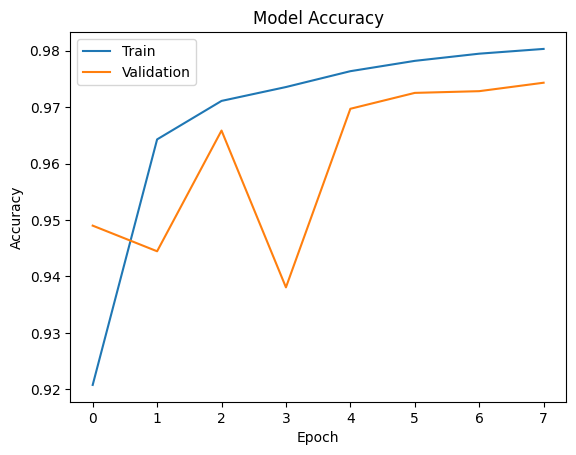

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

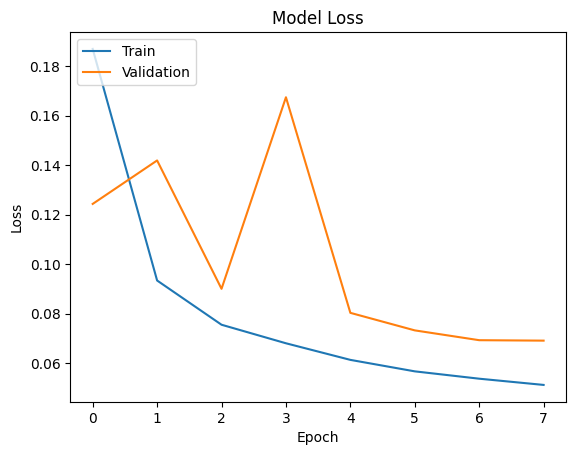

In [14]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [15]:
evaluation = model.evaluate(test_set)

341/341 [==============================] - 28s 83ms/step - loss: 0.2160 - accuracy: 0.9146


In [16]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_set)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

341/341 [==============================] - 25s 74ms/step - loss: 0.2160 - accuracy: 0.9146

Test Loss: 0.2160
Test Accuracy: 0.9146


In [17]:
# Predict the classes using the test set
test_pred = model.predict(test_set)
test_pred_classes = np.round(test_pred)

# Get the true classes of the test set
test_true_classes = test_set.classes

341/341 [==============================] - 30s 84ms/step


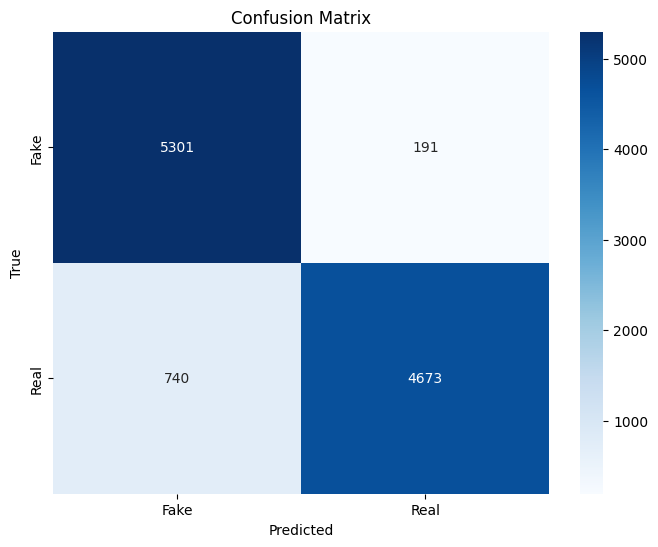

In [18]:
# Plot confusion matrix as a heatmap
# Generate confusion matrix
cm = confusion_matrix(test_true_classes, test_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_set.class_indices.keys(),
            yticklabels=test_set.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# Retrieving class indices
class_indices = training_set.class_indices
print(class_indices)

# Making predictions on the test set
predictions = model.predict(test_set)
predicted_classes = (predictions > 0.5).astype("int32")

# Mapping predictions to class names
class_labels = {v: k for k, v in class_indices.items()}
predicted_class_names = [class_labels[pred[0]] for pred in predicted_classes]

# Printing out the first few predictions with filenames
for i in range(10):
    print(f"Filename: {test_set.filenames[i]}, Predicted: {predicted_class_names[i]}")

{'Fake': 0, 'Real': 1}
341/341 [==============================] - 37s 108ms/step
Filename: Fake/fake_0.jpg, Predicted: Fake
Filename: Fake/fake_1.jpg, Predicted: Fake
Filename: Fake/fake_10.jpg, Predicted: Fake
Filename: Fake/fake_100.jpg, Predicted: Fake
Filename: Fake/fake_1000.jpg, Predicted: Fake
Filename: Fake/fake_1001.jpg, Predicted: Fake
Filename: Fake/fake_1002.jpg, Predicted: Fake
Filename: Fake/fake_1003.jpg, Predicted: Fake
Filename: Fake/fake_1004.jpg, Predicted: Fake
Filename: Fake/fake_1005.jpg, Predicted: Fake


1/1 [==============================] - 4s 4s/step


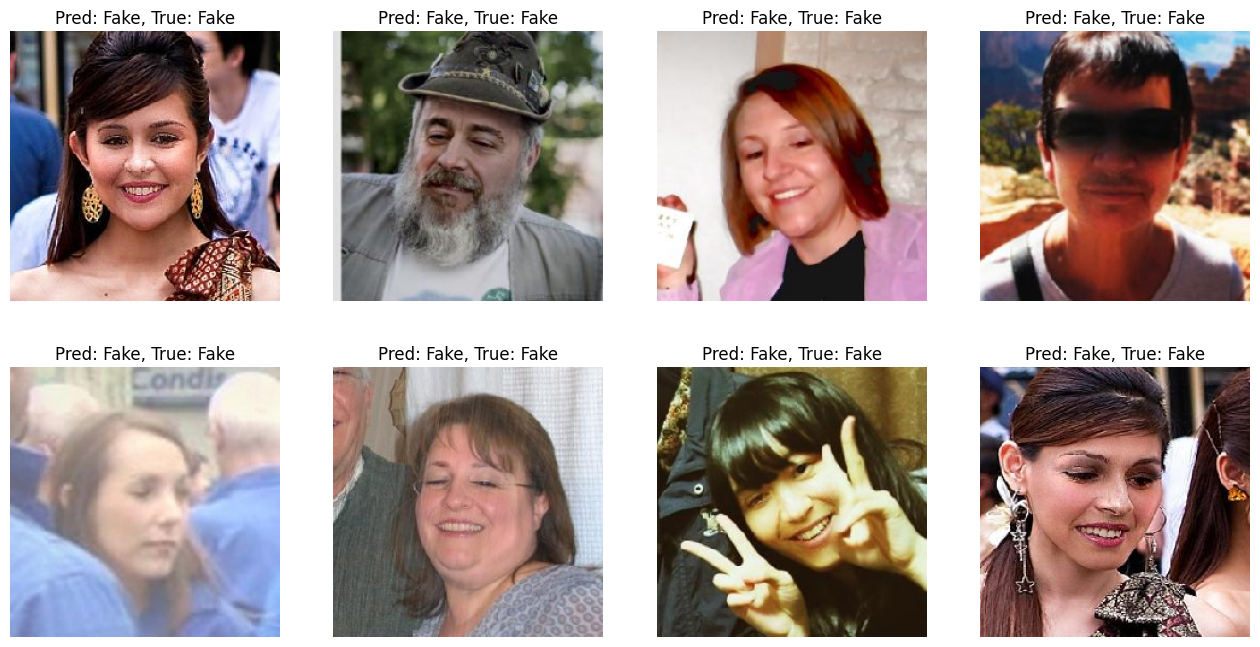

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Function to load random images from the test set
def load_random_images(data_generator, num_images=8):
    # Select random batch and image indices
    total_batches = len(data_generator)
    selected_batches = random.sample(range(total_batches), num_images // data_generator.batch_size + 1)

    images = []
    labels = []
    for batch_index in selected_batches:
        batch_images, batch_labels = data_generator[batch_index]
        images.extend(batch_images)
        labels.extend(batch_labels)

    selected_indices = random.sample(range(len(images)), num_images)
    random_images = [images[i] for i in selected_indices]
    random_labels = [labels[i] for i in selected_indices]

    return np.array(random_images), np.array(random_labels)

# Load 8 random images from the test set
random_images, random_labels = load_random_images(test_set, num_images=8)

# Predict using the model
predictions = model.predict(random_images)
predicted_classes = np.round(predictions).astype(int).flatten()

# Map labels to class names
class_names = {v: k for k, v in test_set.class_indices.items()}

# Display the images with their predicted labels
plt.figure(figsize=(16, 8))
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(random_images[i])
    plt.title(f"Pred: {class_names[predicted_classes[i]]}, True: {class_names[int(random_labels[i])]}")
    plt.axis("off")
plt.show()

1/1 [==============================] - 0s 31ms/step


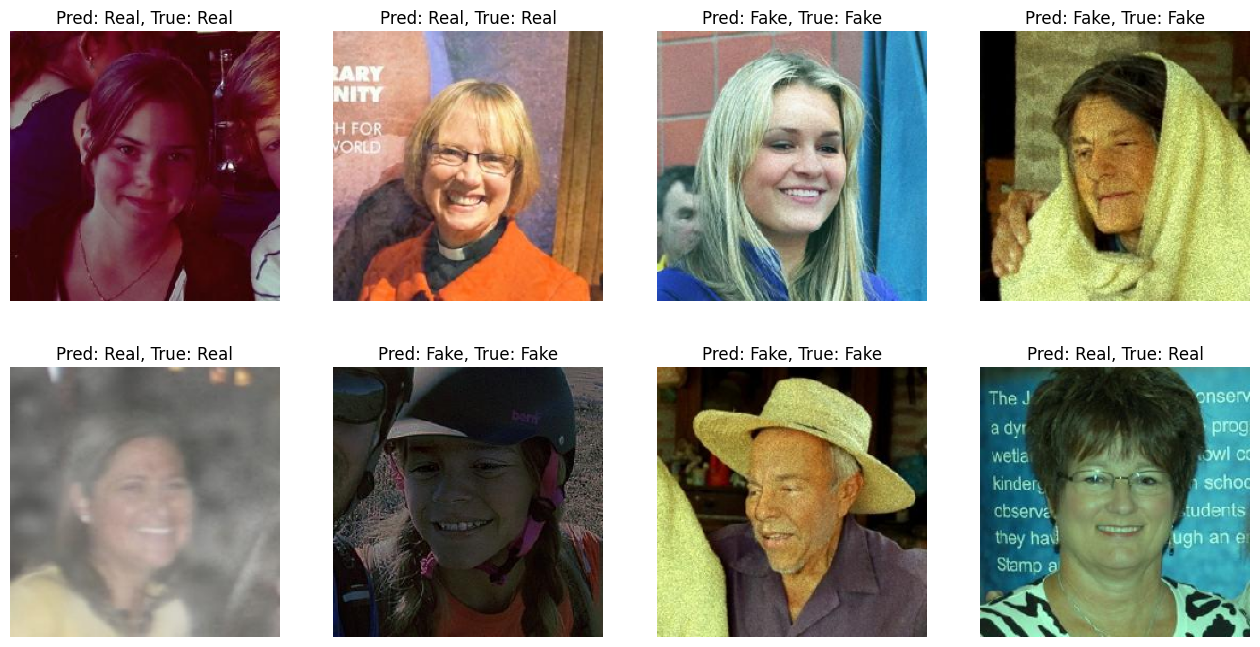

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import random

def load_balanced_random_images(data_generator, num_images=8):
    # Ensure the number of images is even for balanced selection
    num_images_per_class = num_images // 2

    # Initialize lists to hold images and labels
    real_images = []
    fake_images = []
    real_labels = []
    fake_labels = []

    # Loop through batches to collect real and fake images
    for batch_index in range(len(data_generator)):
        batch_images, batch_labels = data_generator[batch_index]
        for image, label in zip(batch_images, batch_labels):
            if label == 1 and len(real_images) < num_images_per_class:
                real_images.append(image)
                real_labels.append(label)
            elif label == 0 and len(fake_images) < num_images_per_class:
                fake_images.append(image)
                fake_labels.append(label)
            if len(real_images) >= num_images_per_class and len(fake_images) >= num_images_per_class:
                break
        if len(real_images) >= num_images_per_class and len(fake_images) >= num_images_per_class:
            break

    # Combine real and fake images and labels
    images = real_images + fake_images
    labels = real_labels + fake_labels

    # Shuffle the combined list
    combined = list(zip(images, labels))
    random.shuffle(combined)
    images, labels = zip(*combined)

    return np.array(images), np.array(labels)

# Load 8 balanced random images from the test set
random_images, random_labels = load_balanced_random_images(test_set, num_images=8)

# Predict using the model
predictions = model.predict(random_images)
predicted_classes = np.round(predictions).astype(int).flatten()

# Map labels to class names
class_names = {v: k for k, v in test_set.class_indices.items()}

# Display the images with their predicted labels
plt.figure(figsize=(16, 8))
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(random_images[i])
    plt.title(f"Pred: {class_names[predicted_classes[i]]}, True: {class_names[int(random_labels[i])]}")
    plt.axis("off")
plt.show()

1/1 [==============================] - 0s 26ms/step


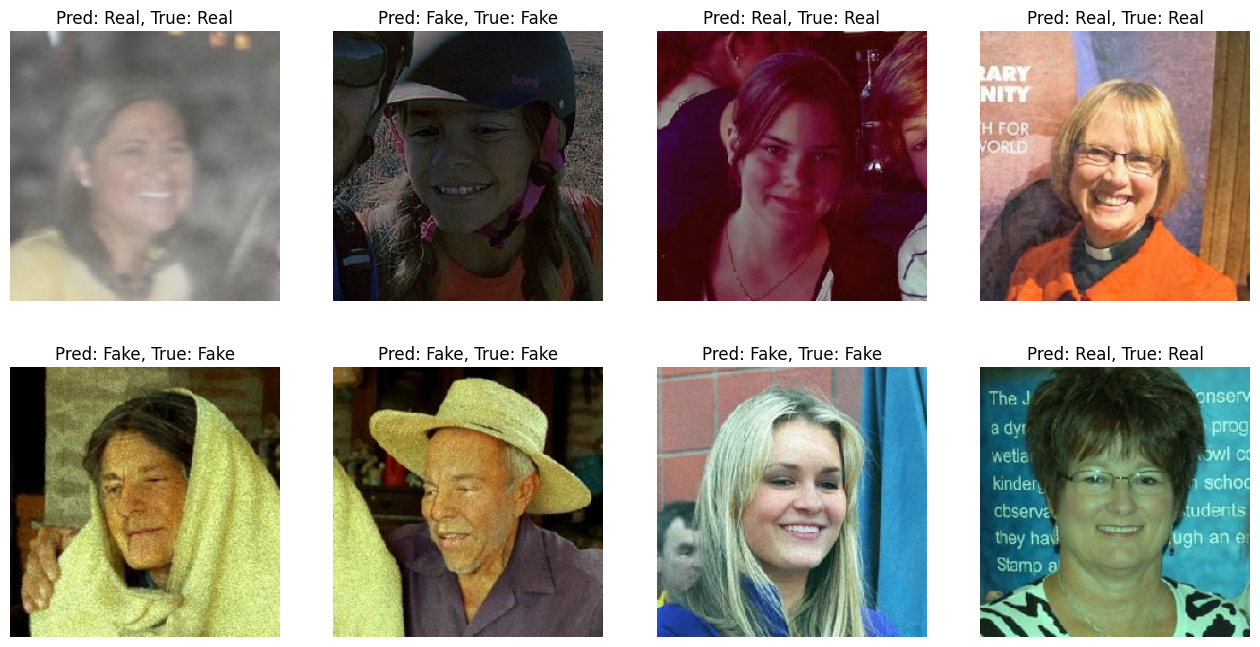

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import random

def load_balanced_random_images(data_generator, num_images=8):
    # Ensure the number of images is even for balanced selection
    num_images_per_class = num_images // 2

    # Initialize lists to hold images and labels
    real_images = []
    fake_images = []
    real_labels = []
    fake_labels = []

    # Loop through batches to collect real and fake images
    for batch_index in range(len(data_generator)):
        batch_images, batch_labels = data_generator[batch_index]
        for image, label in zip(batch_images, batch_labels):
            if label == 1 and len(real_images) < num_images_per_class:
                real_images.append(image)
                real_labels.append(label)
            elif label == 0 and len(fake_images) < num_images_per_class:
                fake_images.append(image)
                fake_labels.append(label)
            if len(real_images) >= num_images_per_class and len(fake_images) >= num_images_per_class:
                break
        if len(real_images) >= num_images_per_class and len(fake_images) >= num_images_per_class:
            break

    # Combine real and fake images and labels
    images = real_images + fake_images
    labels = real_labels + fake_labels

    # Shuffle the combined list
    combined = list(zip(images, labels))
    random.shuffle(combined)
    images, labels = zip(*combined)

    return np.array(images), np.array(labels)

# Load 8 balanced random images from the test set
random_images, random_labels = load_balanced_random_images(test_set, num_images=8)

# Predict using the model
predictions = model.predict(random_images)
predicted_classes = np.round(predictions).astype(int).flatten()

# Map labels to class names
class_names = {v: k for k, v in test_set.class_indices.items()}

# Display the images with their predicted labels
plt.figure(figsize=(16, 8))
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(random_images[i])
    plt.title(f"Pred: {class_names[predicted_classes[i]]}, True: {class_names[int(random_labels[i])]}")
    plt.axis("off")
plt.show()

In [23]:
# Get the best accuracy and validation accuracy
best_train_accuracy = max(history.history['accuracy'])
best_val_accuracy = max(history.history['val_accuracy'])

# Print the best accuracy values
print(f"Best Training Accuracy: {best_train_accuracy * 100:.2f}%")
print(f"Best Validation Accuracy: {best_val_accuracy * 100:.2f}%")

Best Training Accuracy: 98.03%
Best Validation Accuracy: 97.43%


In [24]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
